In [1]:
import datashader as ds
import datashader.transfer_functions as tf
import datashader.glyphs
from datashader import reductions
from datashader.core import bypixel
from datashader.utils import lnglat_to_meters as webm, export_image
from datashader.colors import colormap_select, Greys9, viridis, inferno
import copy


from pyproj import Proj, transform
import numpy as np
import pandas as pd
import urllib
import json
import datetime
import colorlover as cl

import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools

from shapely.geometry import Point, Polygon, shape
# In order to get shapley, you'll need to run [pip install shapely.geometry] from your terminal

from functools import partial

from IPython.display import GeoJSON

py.init_notebook_mode()

For module 2 we'll be looking at techniques for dealing with big data. In particular binning strategies and the datashader library (which possibly proves we'll never need to bin large data for visualization ever again.)

To demonstrate these concepts we'll be looking at the PLUTO dataset put out by New York City's department of city planning. PLUTO contains data about every tax lot in New York City.

PLUTO data can be downloaded from [here](https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_17v1_1.zip). Unzip them to the same directory as this notebook, and you should be able to read them in using this (or very similar) code. Also take note of the data dictionary, it'll come in handy for this assignment.

In [2]:
# Code to read in v17, column names have been updated (without upper case letters) for v18

# bk = pd.read_csv('PLUTO17v1.1/BK2017V11.csv')
# bx = pd.read_csv('PLUTO17v1.1/BX2017V11.csv')
# mn = pd.read_csv('PLUTO17v1.1/MN2017V11.csv')
# qn = pd.read_csv('PLUTO17v1.1/QN2017V11.csv')
# si = pd.read_csv('PLUTO17v1.1/SI2017V11.csv')

# ny = pd.concat([bk, bx, mn, qn, si], ignore_index=True)

ny = pd.read_csv('nyc_pluto_18v2_1_csv/pluto_18v2_1.csv')


# Getting rid of some outliers
ny = ny[(ny['yearbuilt'] > 1850) & (ny['yearbuilt'] < 2020) & (ny['numfloors'] != 0)]

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning:

Columns (16,17,18,20,22,77) have mixed types. Specify dtype option on import or set low_memory=False.



I'll also do some prep for the geographic component of this data, which we'll be relying on for datashader.

You're not required to know how I'm retrieving the lattitude and longitude here, but for those interested: this dataset uses a flat x-y projection (assuming for a small enough area that the world is flat for easier calculations), and this needs to be projected back to traditional lattitude and longitude.

In [3]:


wgs84 = Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")
nyli = Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
ny['xcoord'] = 0.3048*ny['xcoord']
ny['ycoord'] = 0.3048*ny['ycoord']
ny['lon'], ny['lat'] = transform(nyli, wgs84, ny['xcoord'].values, ny['ycoord'].values)

ny = ny[(ny['lon'] < -60) & (ny['lon'] > -100) & (ny['lat'] < 60) & (ny['lat'] > 20)]

#Defining some helper functions for DataShader
background = "black"
export = partial(export_image, background = background, export_path="export")
cm = partial(colormap_select, reverse=(background!="black"))

## Part 1: Binning and Aggregation

Binning is a common strategy for visualizing large datasets. Binning is inherent to a few types of visualizations, such as histograms and [2D histograms](https://plot.ly/python/2D-Histogram/) (also check out their close relatives: [2D density plots](https://plot.ly/python/2d-density-plots/) and the more general form: [heatmaps](https://plot.ly/python/heatmaps/).

While these visualization types explicitly include binning, any type of visualization used with aggregated data can be looked at in the same way. For example, lets say we wanted to look at building construction over time. This would be best viewed as a line graph, but we can still think of our results as being binned by year:

In [4]:
trace = go.Scatter(
    # I'm choosing BBL here because I know it's a unique key.
    x = ny.groupby('yearbuilt').count()['bbl'].index,
    y = ny.groupby('yearbuilt').count()['bbl']
)

layout = go.Layout(
    xaxis = dict(title = 'Year Built'),
    yaxis = dict(title = 'Number of Lots Built')
)

fig = go.Figure(data = [trace], layout = layout)

py.iplot(fig)

Something looks off... You're going to have to deal with this imperfect data to answer this first question. 

But first: some notes on pandas. Pandas dataframes are a different beast than R dataframes, here are some tips to help you get up to speed:

---

Hello all, here are some pandas tips to help you guys through this homework:

[Indexing and Selecting](https://pandas.pydata.org/pandas-docs/stable/indexing.html): .loc and .iloc are the analogs for base R subsetting, or filter() in dplyr

[Group By](https://pandas.pydata.org/pandas-docs/stable/groupby.html):  This is the pandas analog to group_by() and the appended function the analog to summarize(). Try out a few examples of this, and display the results in Jupyter. Take note of what's happening to the indexes, you'll notice that they'll become hierarchical. I personally find this more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. Once you perform an aggregation, try running the resulting hierarchical datafrome through a [reset_index()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html).

[Reset_index](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.reset_index.html): I personally find the hierarchical indexes more of a burden than a help, and this sort of hierarchical indexing leads to a fundamentally different experience compared to R dataframes. reset_index() is a way of restoring a dataframe to a flatter index style. Grouping is where you'll notice it the most, but it's also useful when you filter data, and in a few other split-apply-combine workflows. With pandas indexes are more meaningful, so use this if you start getting unexpected results.

Indexes are more important in Pandas than in R. If you delve deeper into the using python for data science, you'll begin to see the benefits in many places (despite the personal gripes I highlighted above.) One place these indexes come in handy is with time series data. The pandas docs have a [huge section](http://pandas.pydata.org/pandas-docs/stable/timeseries.html) on datetime indexing. In particular, check out [resample](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html), which provides time series specific aggregation.

[Merging, joining, and concatenation](https://pandas.pydata.org/pandas-docs/stable/merging.html): There's some overlap between these different types of merges, so use this as your guide. Concat is a single function that replaces cbind and rbind in R, and the results are driven by the indexes. Read through these examples to get a feel on how these are performed, but you will have to manage your indexes when you're using these functions. Merges are fairly similar to merges in R, similarly mapping to SQL joins.

Apply: This is explained in the "group by" section linked above. These are your analogs to the plyr library in R. Take note of the lambda syntax used here, these are anonymous functions in python. Rather than predefining a custom function, you can just define it inline using lambda.

Browse through the other sections for some other specifics, in particular reshaping and categorical data (pandas' answer to factors.) Pandas can take a while to get used to, but it is a pretty strong framework that makes more advanced functions easier once you get used to it. Rolling functions for example follow logically from the apply workflow (and led to the best google results ever when I first tried to find this out and googled "pandas rolling")

Google Wes Mckinney's book "Python for Data Analysis," which is a cookbook style intro to pandas. It's an O'Reilly book that should be pretty available out there.

---

### Question

After a few building collapses, the City of New York is going to begin investigating older buildings for safety. The city is particularly worried about buildings that were unusually tall when they were built, since best-practices for safety hadn’t yet been determined. Create a graph that shows how many buildings of a certain number of floors were built in each year (note: you may want to use a log scale for the number of buildings). Find a strategy to bin buildings (It should be clear 20-29-story buildings, 30-39-story buildings, and 40-49-story buildings were first built in large numbers, but does it make sense to continue in this way as you get taller?)

### QUESTION ONE ANSWER

From the PLUTO data dictionary, we see that there is an accuracy problem with the YEAR BUILT feature in the dataset:

"YEAR BUILT is accurate for the decade, but not necessarily for the specific year. Between 1910 and 1985, the majority of YEAR BUILT values are in years ending in 5 or 0. A large number of structures built between 1800s and early 1900s have a YEAR BUILT between 1899 and 1901."

To counter this problem, the Year Built will be rounded down to the decade for all entries. 

In [5]:
# Start your answer here, inserting more cells as you go along
ny_floors = ny[['yearbuilt', 'numfloors','bbl']].copy()
ny_floors.sort_values(by=['yearbuilt'], inplace = True) 

ny_floors.head(5)



yearbuilt  numfloors           bbl
82468      1851.0        5.0  1.008238e+09
792937     1851.0        4.0  1.007460e+09
600228     1851.0        3.0  3.002370e+09
493461     1851.0        3.0  3.002250e+09
780213     1851.0        3.0  3.002370e+09

I began by copying the 'yearbuilt', 'numfloors', and 'bbl (building lots) fields into a new dataframe called ny_floors, and in the next cell, I checked for any missing values.

In [6]:
ny_floors.isnull().values.any()

False

In [7]:
ny_floors.dropna(inplace=True)
ny_floors.shape

(812431, 3)

In the next cell, I aggregate the number of floors and the number of buildings per decade into a new dataframe called ny_decade. 

In [8]:
ny_floors['decadebuilt'] = (np.floor(ny_floors['yearbuilt'] / 10.0).astype(int) * 10)
data = {
        'NumFloorsBuilt':ny_floors.groupby('decadebuilt').sum()['numfloors'],
        'NumBuildings':ny_floors.groupby('decadebuilt').count()['bbl']       
       } 
ny_decade = pd.DataFrame(data) 

ny_decade

NumFloorsBuilt  NumBuildings
decadebuilt                              
1850                 328.75            90
1860                 323.50            87
1870                 335.75           118
1880                1317.25           374
1890               65281.66         25412
1900              138079.95         45773
1910              190790.75         67086
1920              451937.45        180365
1930              325855.48        139873
1940              128600.27         66642
1950              149234.99         80358
1960              143072.84         62846
1970               76293.50         32646
1980               71717.55         27330
1990               71223.82         29011
2000              124761.88         43073
2010               44772.85         11347

In the next cell, I graphed a bar plot for the decade using plotly. 

In [9]:
x = ny_decade.index
fig = go.Figure(go.Bar(x =x, y=ny_decade['NumBuildings'], name='No. of Buildings'))
fig.add_trace(go.Bar(x=x, y=ny_decade['NumFloorsBuilt'], name='No. of Floors'))

fig.update_layout(barmode='stack',
                    title=go.layout.Title(
                    text="Buildings and Floors from 1850 to 2010",
                    x=0.5
                    ),
                  yaxis = go.layout.YAxis(
                            dict(type='log'),
                            title=go.layout.yaxis.Title(
                                text="Total Building Lots with Total Floors")),
                            
                  xaxis = go.layout.XAxis(
                          title=go.layout.xaxis.Title(
                          text="Decade Built"))
                 

)
fig.show()

This plot hides details about the floors. Here, it's all of the floors for all of the buildings which does not relay enough detail to the decision makers.  We cannot tell which building is more than likely to collapse.

From a 1% sample of the floors, we see that some floors are not whole numbers. To remedy that, I rounded the floors to the next highest level, e.g. a 2.5 floor building becomes a 3.0 floor building.  I did this in order to consolidate the number of floors into whole numbers in order to provide more details to the plot.

In [10]:
import sys
np.set_printoptions(threshold=sys.maxsize)
np.sort(ny_floors[ 'numfloors'].sample(frac=0.0001, replace=True, random_state=1))

array([ 1.  ,  1.  ,  1.5 ,  1.5 ,  1.5 ,  1.67,  2.  ,  2.  ,  2.  ,
        2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,
        2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,
        2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,
        2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,  2.  ,
        2.  ,  2.  ,  2.  ,  2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ,
        2.5 ,  2.5 ,  2.5 ,  2.5 ,  2.5 ,  3.  ,  3.  ,  3.  ,  3.  ,
        3.  ,  3.  ,  3.  ,  3.  ,  3.  ,  3.  ,  3.  ,  3.  ,  4.  ,
        4.  ,  5.  ,  5.  ,  6.  ,  6.  ,  6.  ,  7.  , 13.  , 15.  ])

In [11]:
ny_floors[ 'numfloors'] = np.ceil(ny_floors[ 'numfloors'])

In [12]:
np.sort(ny_floors[ 'numfloors'].sample(frac=0.0001, replace=True, random_state=1))

array([ 1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
        3.,  3.,  3.,  3.,  3.,  3.,  4.,  4.,  5.,  5.,  6.,  6.,  6.,
        7., 13., 15.])

To add more details to the plot, I created a new field in the dataset called 'level'. This has the effect of creating different sized bins.  Since the majority of the floors are 1 to 2 levels, it should have its own bins.

In [13]:
Levels = {
    1: "Level 1: 1-2 Floors",
    2: "Level 2: 3-4 Floors",
    3: "Level 3: 5-8 Floors",
    4: "Level 4: 9-12 Floors",
    5: "Level 5: 13-15 Floors",
    6: "Level 6: Over 15 Floors"
   
    
}

def floorLevel(floor):
    if floor <=2:
        return Levels[1]
    elif floor > 2 and floor <= 4:
        return Levels[2]
    elif floor > 4 and floor <= 8:
        return Levels[3]
    elif floor > 8 and floor <= 12:
        return Levels[4]
    elif floor > 12 and floor <= 15:
        return Levels[5]
    elif floor > 15:
        return Levels[6]
    
    
    


In [14]:
ny_floors['level']= ""
ny_floors['level']= ny_floors['numfloors'].apply(floorLevel)

In [15]:
ny_floors.head(5)

yearbuilt  numfloors           bbl  decadebuilt                level
82468      1851.0        5.0  1.008238e+09         1850  Level 3: 5-8 Floors
792937     1851.0        4.0  1.007460e+09         1850  Level 2: 3-4 Floors
600228     1851.0        3.0  3.002370e+09         1850  Level 2: 3-4 Floors
493461     1851.0        3.0  3.002250e+09         1850  Level 2: 3-4 Floors
780213     1851.0        3.0  3.002370e+09         1850  Level 2: 3-4 Floors

In this next cell, I unstacked the data so that the 'level' categories become fields. This was after I aggregated the counts for the decadebuilt and the levels.

In [16]:
ny_floors2 = pd.DataFrame(ny_floors.groupby(['decadebuilt','level']).count()['bbl'].unstack(level=1))
ny_floors2.reset_index(level=ny_floors2.index.names, inplace=True)
ny_floors2

level  decadebuilt  Level 1: 1-2 Floors  Level 2: 3-4 Floors  \
0             1850                 10.0                 64.0   
1             1860                  9.0                 63.0   
2             1870                 70.0                 29.0   
3             1880                 99.0                180.0   
4             1890              11439.0              13629.0   
5             1900              19088.0              20621.0   
6             1910              32839.0              26519.0   
7             1920             104083.0              66394.0   
8             1930              88145.0              48087.0   
9             1940              58960.0               6609.0   
10            1950              73541.0               5231.0   
11            1960              48701.0              12149.0   
12            1970              25112.0               6837.0   
13            1980              18433.0               8175.0   
14            1990              18864.0               9612.0   
15            2000              23809.0              16356.0   
16            2010               5420.0               3780.0   

level  Level 3: 5-8 Floors  Level 4: 9-12 Floors  Level 5: 13-15 Floors  \
0                     15.0                   1.0                    NaN   
1                     13.0                   2.0                    NaN   
2                     18.0                   1.0                    NaN   
3                     93.0                   1.0                    1.0   
4                    325.0                  11.0                    2.0   
5                   5581.0                 356.0                   78.0   
6                   6992.0                 515.0                  109.0   
7                   8528.0                 475.0                  412.0   
8                   3257.0                 122.0                   64.0   
9                    949.0                  52.0                   36.0   
10                  1184.0                  92.0                  119.0   
11                  1108.0                 136.0                  172.0   
12                   321.0                  69.0                   52.0   
13                   266.0                 111.0                   60.0   
14                   350.0                  67.0                   20.0   
15                  2161.0                 322.0                  113.0   
16                  1508.0                 293.0                   83.0   

level  Level 6: Over 15 Floors  
0                          NaN  
1                          NaN  
2                          NaN  
3                          NaN  
4                          6.0  
5                         49.0  
6                        112.0  
7                        473.0  
8                        198.0  
9                         36.0  
10                       191.0  
11                       580.0  
12                       255.0  
13                       285.0  
14                        98.0  
15                       312.0  
16                       263.0

In [17]:
x = ny_floors2['decadebuilt']

fig = go.Figure(data=[
go.Bar(name='Level 1: 1-2 Floors', x=x, y=ny_floors2['Level 1: 1-2 Floors']),
go.Bar(name='Level 2: 3-4 Floors', x=x, y=ny_floors2['Level 2: 3-4 Floors']), 
go.Bar(name='Level 3: 5-8 Floors', x=x, y=ny_floors2['Level 3: 5-8 Floors']),
go.Bar(name='Level 4: 9-12 Floors', x=x, y=ny_floors2['Level 4: 9-12 Floors']),
go.Bar(name='Level 5: 13-15 Floors', x=x, y=ny_floors2['Level 5: 13-15 Floors']),
go.Bar(name='Level 6: Over 15 Floors', x=x, y=ny_floors2['Level 6: Over 15 Floors']),

])
fig.update_layout(barmode='stack',
                  title=go.layout.Title(
                    text="Buildings and Floors from 1850 to 2010",
                    x=0.5
                    ),
                  yaxis = go.layout.YAxis(
                            dict(type='log'),
                            title=go.layout.yaxis.Title(
                                text="Total Building Lots")),
                  xaxis = go.layout.XAxis(
                          title=go.layout.xaxis.Title(
                          text="Decade Built"))
                 )
fig.show()


### FINAL ANSWER

In the visualization above, I was able to get a level of detail about the number buildings built per decade along with the number of floors.  By clicking on the legend to the right, I was able to isolate the number of buildings built per decade with the number of floors.  

For example, if I want to see the number of buildings with 13-15 floors, I can click on the other categories thus isolating Level 5. This shows that 412 buildings with 13-15 floors were built in 1920. 

This gives a level of detail that policy makers need to make an informed decision.

## Part 2: Datashader

Datashader is a library from Anaconda that does away with the need for binning data. It takes in all of your datapoints, and based on the canvas and range returns a pixel-by-pixel calculations to come up with the best representation of the data. In short, this completely eliminates the need for binning your data.

As an example, lets continue with our question above and look at a 2D histogram of YearBuilt vs NumFloors:

In [18]:
yearbins = 200
floorbins = 200

yearBuiltCut = pd.cut(ny['yearbuilt'], np.linspace(ny['yearbuilt'].min(), ny['yearbuilt'].max(), yearbins))
numFloorsCut = pd.cut(ny['numfloors'], np.logspace(1, np.log(ny['numfloors'].max()), floorbins))

xlabels = np.floor(np.linspace(ny['yearbuilt'].min(), ny['yearbuilt'].max(), yearbins))
ylabels = np.floor(np.logspace(1, np.log(ny['numfloors'].max()), floorbins))

data = [
    go.Heatmap(z = ny.groupby([numFloorsCut, yearBuiltCut])['bbl'].count().unstack().fillna(0).values,
              colorscale = 'Greens', x = xlabels, y = ylabels)
]

py.iplot(data)

This shows us the distribution, but it's subject to some biases discussed in the Anaconda notebook [Plotting Perils](https://anaconda.org/jbednar/plotting_pitfalls/notebook). 

Here is what the same plot would look like in datashader:



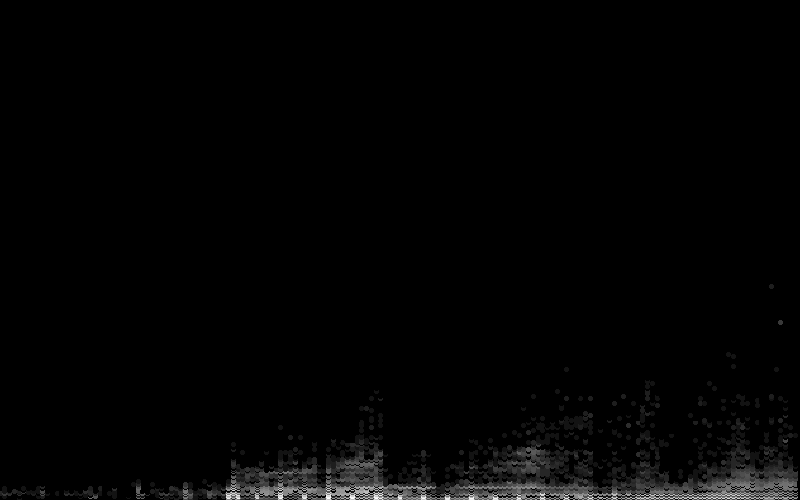

In [19]:
cvs = ds.Canvas(800, 500, x_range = (ny['yearbuilt'].min(), ny['yearbuilt'].max()), 
                                y_range = (ny['numfloors'].min(), ny['numfloors'].max()))
agg = cvs.points(ny, 'yearbuilt', 'numfloors')
view = tf.shade(agg, cmap = cm(Greys9), how='log')
export(tf.spread(view, px=2), 'yearvsnumfloors')

That's technically just a scatterplot, but the points are smartly placed and colored to mimic what one gets in a heatmap. Based on the pixel size, it will either display individual points, or will color the points of denser regions.

Datashader really shines when looking at geographic information. Here are the latitudes and longitudes of our dataset plotted out, giving us a map of the city colored by density of structures:

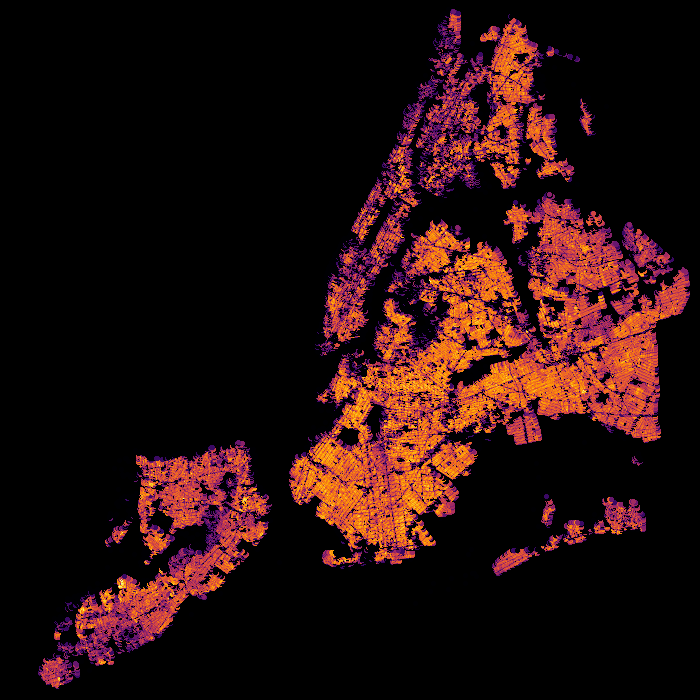

In [20]:
NewYorkCity   = (( -74.29,  -73.69), (40.49, 40.92))
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny, 'lon', 'lat')
view = tf.shade(agg, cmap = cm(inferno), how='log')
export(tf.spread(view, px=2), 'firery')

Interestingly, since we're looking at structures, the large buildings of Manhattan show up as less dense on the map. The densest areas measured by number of lots would be single or multi family townhomes.

Unfortunately, Datashader doesn't have the best documentation. Browse through the examples from their [github repo](https://github.com/bokeh/datashader/tree/master/examples). I would focus on the [visualization pipeline](https://anaconda.org/jbednar/pipeline/notebook) and the [US Census](https://anaconda.org/jbednar/census/notebook) Example for the question below. Feel free to use my samples as templates as well when you work on this problem.

### Question

You work for a real estate developer and are researching underbuilt areas of the city. After looking in the [Pluto data dictionary](https://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/pluto_datadictionary.pdf?v=17v1_1), you've discovered that all tax assessments consist of two parts: The assessment of the land and assessment of the structure. You reason that there should be a correlation between these two values: more valuable land will have more valuable structures on them (more valuable in this case refers not just to a mansion vs a bungalow, but an apartment tower vs a single family home). Deviations from the norm could represent underbuilt or overbuilt areas of the city. You also recently read a really cool blog post about [bivariate choropleth maps](http://www.joshuastevens.net/cartography/make-a-bivariate-choropleth-map/), and think the technique could be used for this problem.

Datashader is really cool, but it's not that great at labeling your visualization. Don't worry about providing a legend, but provide a quick explanation as to which areas of the city are overbuilt, which areas are underbuilt, and which areas are built in a way that's properly correlated with their land value.

### QUESTION TWO ANSWER
First, I printed out all of the column names to ensure that 'assessland' and 'assesstot' are the only two assessments. Next, I copy over the 'lon', 'lat', 'assessland', and 'assesstot' over into a new dataframe called, ny_lots.

In [21]:
ny.columns.sort_values()


Index(['address', 'appbbl', 'appdate', 'areasource', 'assessland', 'assesstot',
       'basempdate', 'bbl', 'bldgarea', 'bldgclass', 'bldgdepth', 'bldgfront',
       'block', 'borocode', 'borough', 'bsmtcode', 'builtfar', 'cb2010', 'cd',
       'comarea', 'commfar', 'condono', 'council', 'ct2010', 'dcasdate',
       'easements', 'edesigdate', 'edesignum', 'exemptland', 'exempttot',
       'ext', 'facilfar', 'factryarea', 'firecomp', 'firm07_flag',
       'garagearea', 'healtharea', 'healthcenterdistrict', 'histdist',
       'irrlotcode', 'landmark', 'landmkdate', 'landuse', 'lat', 'lon', 'lot',
       'lotarea', 'lotdepth', 'lotfront', 'lottype', 'ltdheight', 'mappluto_f',
       'masdate', 'numbldgs', 'numfloors', 'officearea', 'otherarea',
       'overlay1', 'overlay2', 'ownername', 'ownertype', 'pfirm15_flag',
       'plutomapid', 'policeprct', 'polidate', 'proxcode', 'resarea',
       'residfar', 'retailarea', 'rpaddate', 'sanborn', 'sanitboro',
       'sanitdistrict', 'sanitsub', 

In [22]:
ny_lots = ny[['lon', 'lat', 'assessland', 'assesstot']].copy()

From the column names, I saw that assesstot is a combination of assessedland and assessbldg.  By subtracting assessland from assesstot, if found the assessbldg value. When I took a correlation between the two variables, I found a fairly high correlation between the two with an R score of 0.8123

In [23]:
ny_lots['assessbldg'] = ny_lots['assesstot']-ny_lots['assessland']

In [24]:
np.corrcoef(ny_lots['assessbldg'],ny_lots['assessland'])

array([[1.        , 0.81353967],
       [0.81353967, 1.        ]])

Next, I created a new variable for the ny_lots dataframe called, 'assessland_to_assessbldg_pct' which is a ratio of the value of the land to the value of the building.  The higher the percentage means that the land is more valuable than the building which would mean that the land is underbuilt.

In [25]:
ny_lots['assessland_to_assessbldg_pct'] = ny_lots['assessland'] / ny_lots['assessbldg'] 


One problem that I encountered was that the building values were 0 which makes the assessland_to_assessbldg_pct infinity. According to the Pluto data dictionary:

"Property value is assessed as of January 5th. If a new building is not completed by April 14th, the assessed building value is 0 and the Building Class reverts to Vacant"

To account for this and prevent infinity, I converted buildings with assessed value of 0 to an assessed value of 1. 

In [26]:
ny_lots[(ny_lots['assessbldg']==0)].head(5)

lon        lat  assessland  assesstot  assessbldg  \
131 -74.133977  40.578414     17083.0    17083.0         0.0   
280 -74.222623  40.541419      8093.0     8093.0         0.0   
563 -74.205993  40.529628     11320.0    11320.0         0.0   
751 -73.969524  40.639173     45600.0    45600.0         0.0   
899 -74.008619  40.727083    675000.0   675000.0         0.0   

     assessland_to_assessbldg_pct  
131                           inf  
280                           inf  
563                           inf  
751                           inf  
899                           inf

In [27]:
ny_lots.loc[ny_lots.assessbldg == 0, 'assessland_to_assessbldg_pct'] =1


In [28]:
ny_lots.sort_values(by=['assessland_to_assessbldg_pct']).head(10)

lon        lat  assessland   assesstot  assessbldg  \
207    -74.001280  40.696995       103.0   1892700.0   1892597.0   
123238 -73.833648  40.755185       898.0    722249.0    721351.0   
120884 -73.949442  40.688829        81.0     63564.0     63483.0   
120463 -73.976691  40.681103       119.0     91605.0     91486.0   
160430 -73.970248  40.793524     37335.0  28105862.0  28068527.0   
120680 -73.985355  40.661408       754.0    520380.0    519626.0   
161562 -73.985999  40.670974       174.0    118558.0    118384.0   
122492 -73.964194  40.628395        63.0     38004.0     37941.0   
110239 -73.968670  40.686185       203.0    115485.0    115282.0   
789330 -73.938697  40.692596      1020.0    511320.0    510300.0   

        assessland_to_assessbldg_pct  
207                         0.000054  
123238                      0.001245  
120884                      0.001276  
120463                      0.001301  
160430                      0.001330  
120680                      0.001451  
161562                      0.001470  
122492                      0.001660  
110239                      0.001761  
789330                      0.001999

Using the describe function on the 'assessland_to_assessbldg_pct' feature, I thought first to categorize the data by quartiles. However, according to Joshua Stevens, " [it's] recommended to keep things super simple when creating bivariate choropleth maps by not exceeding 3 classes in each variable."

So, I used numpy's quantile function to find the 30th and 67th quantiles of the feature which is at .32 and .545 respectively. I then categorized the data into the 3 classes as recommended in the article.

In [29]:
ny_lots['assessland_to_assessbldg_pct'].describe()

count    812431.000000
mean          0.589803
std          31.010451
min           0.000054
25%           0.290472
50%           0.429979
75%           0.623447
max       22000.000000
Name: assessland_to_assessbldg_pct, dtype: float64

In [30]:
ny_lots['assessland_to_assessbldg_pct'].quantile([.3, .667]) 

0.300    0.319759
0.667    0.545717
Name: assessland_to_assessbldg_pct, dtype: float64

In [31]:
def Tiers(tier):
    if tier <=0.32:
        return "Tier One"
    elif tier > .32 and tier <= 0.545:
        return "Tier Two"
    elif tier > 0.545:
        return "Tier Three"

In [32]:
ny_lots['Tier']=""
ny_lots['Tier']= ny_lots['assessland_to_assessbldg_pct'].apply(Tiers)
ny_lots['Tier'] = ny_lots['Tier'].astype("category")

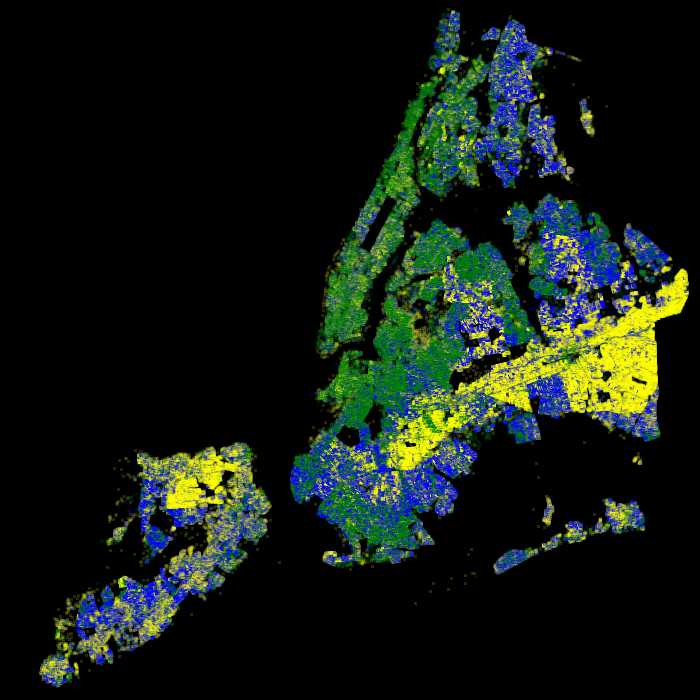

In [33]:
color_key = {'Tier One':'green', 'Tier Two':'blue',  'Tier Three':'yellow' }
cvs = ds.Canvas(700, 700, *NewYorkCity)
agg = cvs.points(ny_lots, 'lon', 'lat', ds.count_cat('Tier'))
view = tf.shade(agg, color_key=color_key)
export(tf.spread(view, px=1), 'cloropleth')

### FINAL ANSWER

Tier One (Green) shows the areas where the assessland_to_assessbldg_pct ratio is less than .32 which shows that the assessed building is generally higher than the assessed land which means that the lots in green ARE NOT underbuilt.

Tier Two (Blue) shows the areas where the assessland_to_assessbldg_pct ratio is between than .32 and .545 which shows that the assessed building is still generally higher with a little more value than Tier One but these lots ARE NOT underbuilt.

Tier Three (Yellow) shows the areas where the assessland_to_assessbldg_pct ratio is over .545 which shows that the assessed land in general is higher than the assessed building these lots ARE UNDERBUILT. 

Areas in Queens, Brooklyn, the upper Bronx, and Staten Island seem to have the most underbuilt lots. 